In [1]:
import sys
sys.path += ['/Users/cswa648/git/phylo-hacking/pymc']
import theano
import newick
from xml.etree import ElementTree

%matplotlib inline

data_xml_filename = '../../data/ratites.SRD06.RLC.YULE.xml'
xml_root = ElementTree.parse(data_xml_filename)
newick_string = xml_root.find('.//newick').text
tree = newick.loads(newick_string)[0]
print(tree.ascii_art())

                            ┌─ANDI
                     ┌──────┤
                     │      └─DIGI
              ┌──────┤
              │      │             ┌─CASS
              │      │      ┌──────┤
       ┌──────┤      └──────┤      └─EMU
       │      │             └─KIWI
───────┤      │
       │      └─RHEA
       └─OST


In [2]:
sequence_dict = { seq_element.find('./taxon').attrib['idref']: list(seq_element.itertext())[-1].strip()
 for seq_element in xml_root.findall('.//sequence') }

from pylo.topology import TreeTopology
topology = TreeTopology(tree)

import numpy as np
from pylo.transform import group_sequences, encode_sequences
sequence_dict_encoded = encode_sequences(sequence_dict)
pattern_dict, pattern_counts = group_sequences(sequence_dict_encoded)
child_patterns = np.array(topology.build_sequence_table(pattern_dict))
pattern_counts = np.array(pattern_counts)

import theano.tensor as tt

child_patterns_ = tt.as_tensor_variable(child_patterns)
pattern_counts_ = tt.as_tensor_variable(pattern_counts)

In [3]:
import pymc3 as pm
from pylo.tree import BirthDeathSamplingTree, TreeHeightProportionTransform
from pylo.hky import HKYSubstitutionModel
from pylo.pruning import LeafSequences

with pm.Model() as model:
    r = pm.Exponential('r', lam=0.1)
    a = pm.Beta('a', alpha=1.0, beta=1.0)
    rho = pm.Beta('rho', alpha=1.0, beta=1.0)
    
    tree_heights = BirthDeathSamplingTree('tree', topology, r, a, rho)
    branch_lengths = pm.Deterministic('branch_lengths', topology.get_child_branch_lengths(tree_heights))
    rates = pm.Lognormal('rates', shape=(topology.get_internal_node_count(), 2))
    
    distances = pm.Deterministic('distances', rates*branch_lengths)
    
    kappa = pm.Exponential('kappa', lam=0.1)
    pi = pm.Dirichlet('pi', a=np.ones(4))
    
    substitution_model = HKYSubstitutionModel(kappa, pi)
    sequences = LeafSequences('sequences', topology, substitution_model, distances, child_patterns_, pattern_counts_)
    
model

/Users/cswa648/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

r_log__ -1.0596601002984285
a_logodds__ -1.3862943611198906
rho_logodds__ -1.3862943611198906
tree_tree_height_proportion__ -64.46607193179358
rates_log__ -11.027262398456068
kappa_log__ -1.0596601002984285
pi_stickbreaking__ -3.753417975251508


Average Loss = 43,097: 100%|██████████| 40000/40000 [08:02<00:00, 82.95it/s]
Finished [100%]: Average Loss = 43,097


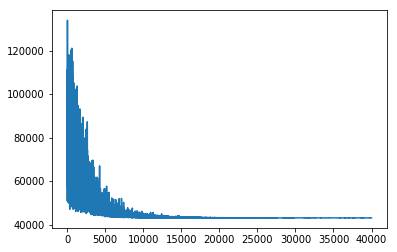

In [7]:
import matplotlib.pyplot as plt

with model:
#    trace = pm.sample(draws=1000, tune=1000, nuts_kwargs=dict(target_accept=.90))
    fit = pm.fit(n=40000)

plt.plot(fit.hist)

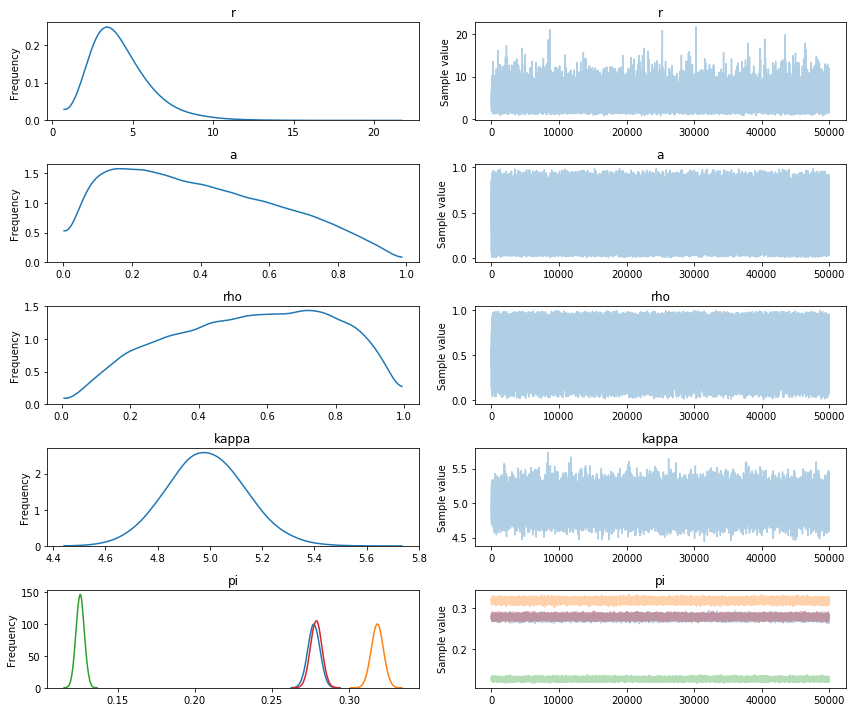

In [12]:
trace = fit.sample(draws=50000)
pm.traceplot(trace, varnames=['r', 'a', 'rho', 'kappa', 'pi']);

In [25]:
log_weight = fit.sized_symbolic_logp - fit.symbolic_logq
log_weight

Elemwise{sub,no_inplace}.0

(array([1.000e+00, 0.000e+00, 1.000e+01, 3.900e+01, 1.680e+02, 7.660e+02,
        2.962e+03, 5.042e+03, 9.850e+02, 2.700e+01]),
 array([-43134.98954155, -43129.6414964 , -43124.29345125, -43118.9454061 ,
        -43113.59736095, -43108.2493158 , -43102.90127065, -43097.55322551,
        -43092.20518036, -43086.85713521, -43081.50909006]),
 <a list of 10 Patch objects>)

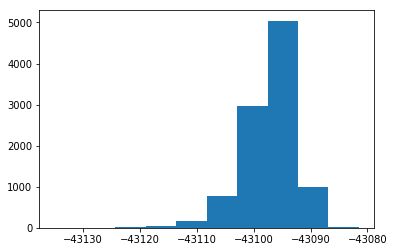

In [39]:
n_samples = 10000
log_weights = fit.set_size_and_deterministic(log_weight, n_samples, False).eval()
plt.hist(log_weights)

(array([1.000e+00, 0.000e+00, 1.000e+01, 3.900e+01, 1.680e+02, 7.660e+02,
        2.962e+03, 5.042e+03, 9.850e+02, 2.700e+01]),
 array([-54.59745969, -49.24941454, -43.90136939, -38.55332424,
        -33.20527909, -27.85723394, -22.50918879, -17.16114364,
        -11.81309849,  -6.46505334,  -1.11700819]),
 <a list of 10 Patch objects>)

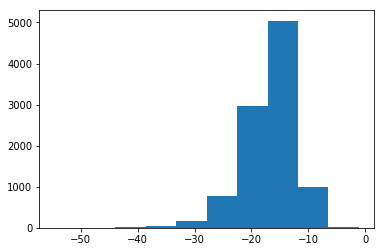

In [40]:
from scipy.special import logsumexp

log_weights_norm = (log_weights - logsumexp(log_weights))[:, np.newaxis]

plt.hist(log_weights_norm)

ValueError: too many values to unpack (expected 1)

In [41]:
pm.stats._psislw(log_weights_norm, n_samples)

(array([[-16.94780319],
        [-18.22472058],
        [-14.58521877],
        ...,
        [-13.18452382],
        [-25.22208332],
        [ -8.83979256]]), array([inf]))